___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://samyzaf.com/ML/cifar10/cifar1.jpg" width="380px" height="180px" />


# <font color= #bbc28d> **Training CNN's - CIFAR NN Models** </font>
#### <font color= #2E9AFE> `Lab 2 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 27/10/2025.

___

<p style="text-align:right;"> Image retrieved from: https://samyzaf.com/ML/cifar10/cifar1.jpg</p>

# <font color= #bbc28d> **Abstract** </font>

The following notebook aims to explore the process of training Convolutional Neural Netowrks (CNN's) with different configurations to evaluate performance, via an image classification of the CIFAR-10 dataset.

----

In [1]:
# === IMPORTS ===

# Generales
import random
import csv
import pandas as pd

# Redes Neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import alexnet, AlexNet_Weights, vgg19, VGG19_Weights
from torchvision import transforms
from torch.nn.init import kaiming_uniform_, xavier_uniform_, orthogonal_, zeros_

# Visualization
import matplotlib.pyplot as plt

In [ ]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Usando dispositivo: cuda


# <font color= #bbc28d> **Data Loading, Visualization and Preprocessing** </font>

In [3]:
# Data Importing
dataset = torch.load("l2_data/cifar10_subset.pt")

In this notebook, we're going to be using the CIFAR-10 dataset, which contains images belonging to 10 different classes:


|Label| Meaning |
|--|--|
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [4]:
label_dict = {
    '0': 'airplane',
    '1': 'automobile',
    '2': 'bird',
    '3': 'cat',
    '4': 'deer',
    '5': 'dog',
    '6': 'frog',
    '7': 'horse',
    '8': 'ship',
    '9': 'truck',
}

These are some of the images available in CIFAR-10:

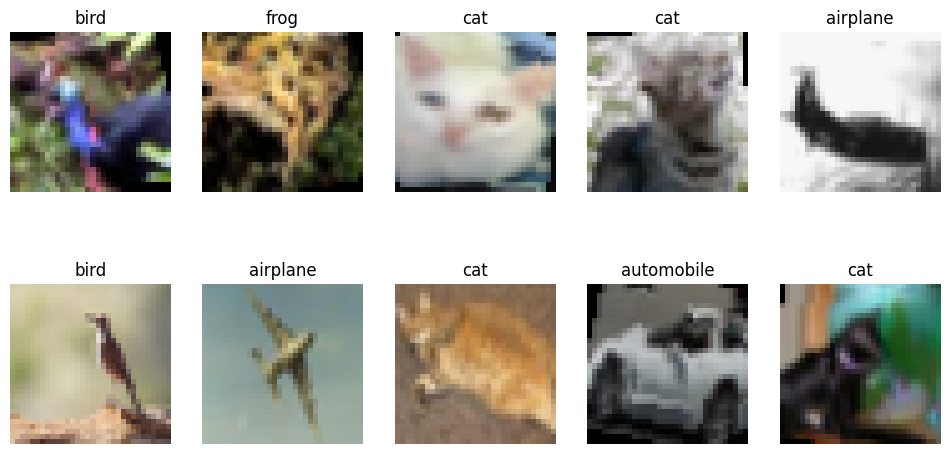

In [5]:
# Quick image preview
images, labels = dataset

idxs = random.sample(range(len(images)), 10)
sample_images = images[idxs]
sample_labels = labels[idxs]

plt.figure(figsize=(12,6))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(2,5, i+ 1)
    plt.imshow(img.permute(1,2,0))
    plt.title(label_dict[str(label.item())])
    plt.axis('off')
plt.show()

Now, we proceed to do a train-test-split for modeling:

In [ ]:
images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False) # To make images 224x224, a requirement for both AlexNet and VGG19

dataset = TensorDataset(images, labels)
train_size = int(0.8 * len(dataset)) # 80% train
test_size = len(dataset) - train_size #20% test
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)) # Same seed so data is always split in the same way

# <font color= #bbc28d> **CNN Configurations** </font>

Since the goal of this notebook is to evaluate the elements involved in training CNN's, not only the architecture of the models, but also the seeds, optimizers, solvers and other hyperparameters of the Neural Networks, we're going to be testing 3 different NN architectures, paired with a combination of hyperparameters, to describe and record the changes in all of the permutations. The selected parameters for the test are the following:

### <font color= #66b0b0> &ensp; **Models** </font>

- AlexNet
- VGG16
- Own Design

### <font color= #66b0b0> &ensp; **Seeds** </font>
- Seed 1
- Seed 2
- Seed 3

### <font color= #66b0b0> &ensp; **Factors & Conditions** </font>

- Optimizers (SGD, Adam, AdamW)
- Regularization (1e-4, 5e-4, 2e-3)
- Batch Size (32, 128, 512)
- Learning-Rate Schedules (StepLR, Cosine, OneCycle)
- Weight Initialization (Kaiming, Xavier, Orthogonal)

This makes up a `total of 135 different Neural Networks`.

In [ ]:
OPTIMIZER_OPTIONS = ['Adam','AdamW','SGD'] # SGD must have a momentum of 0.9
REGULARIZATION_OPTIONS = [1e-4, 5e-4, 2e-3]
BATCH_SIZE_OPTIONS = [32, 128, 512]
LR_SCHEDULES_OPTIONS = ['Constant', 'StepLR', 'Cosine']
WEIGHT_INITIALIZATION_OPTIONS = ['Kaiming', 'Xavier', 'Orthogonal']
SEEDS = [0, 42, 21]
# Subject to change

In [ ]:
BASELINE = {
    'optimizer': 'SGD',
    'reg': 1e-4,
    'batch': 128,
    'schedule': 'Cosine',
    'init': 'Kaiming'
}

# <font color= #bbc28d> **Modeling** </font>

## <font color= #66b0b0> &ensp; • **AlexNet** </font>

In [9]:
# AlexNet helper functions

def init_weights(model, method):
    for i in model.modules():
        if isinstance(i, nn.Linear):
            if method == 'Kaiming':
                kaiming_uniform_(i.weight, nonlinearity='relu')
            elif method == 'Xavier':
                xavier_uniform_(i.weight)
            elif method == 'Orthogonal':
                orthogonal_(i.weight)
            if i.bias is not None:
                zeros_(i.bias)

# Train - Test Loaders
train_loader = DataLoader(train_ds, )

def build_optimizer(model, name, reg):
    if name == 'Adam':
        return optim.Adam(model.parameters(), lr=1e-4, weight_decay=reg)
    elif name == 'AdamW':
        return optim.AdamW(model.parameters(), lr=1e-4, weight_decay=reg)
    elif name == 'SGD':
        return optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=reg)

def build_scheduler(optimizer, name):
    if name == 'StepLR':
        return optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    elif name == 'Cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    else:
        return None

def train_eval_alexnet(model, optimizer, scheduler, seed, train_loader, test_loader):
    torch.manual_seed(seed)
    criterion = torch.nn.CrossEntropyLoss()

    epoch_losses = []

    # Training
    for e in range(15):
        model.train()
        running_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        if scheduler:
            scheduler.step()
        
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    
    final_loss = epoch_losses[-1]
    
    # Evaluation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    
    acc = correct / total
    return acc, final_loss, epoch_losses

def dummy_test():
    acc = random.random()
    loss = random.random()
    epochs = [(random.randint(1,10), random.randint(1,10)) for i in range(10)]
    

    return acc, loss, epochs

In [10]:
# Running AlexNet tests

results = []
categories = {
    'optimizer': OPTIMIZER_OPTIONS,
    'reg': REGULARIZATION_OPTIONS,
    'batch': BATCH_SIZE_OPTIONS,
    'schedule': LR_SCHEDULES_OPTIONS,
    'init': WEIGHT_INITIALIZATION_OPTIONS
}

for category, options in categories.items():
    for option in options:
        cfg = BASELINE.copy()
        cfg[category] = option

        for seed in SEEDS:
            # Model building

            train_loader = DataLoader(train_ds, batch_size=cfg['batch'], shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=cfg['batch'])

            alex_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            alex_model.classifier[6] = nn.Linear(4096, 10)
            init_weights(alex_model, cfg['init'])
            alex_model.to(device)

            optimizer = build_optimizer(alex_model, cfg['optimizer'], cfg['reg'])
            scheduler = build_scheduler(optimizer, cfg['schedule'])
            #acc, final_loss, epoch_losses = train_eval_alexnet(alex_model, optimizer, scheduler, seed, train_loader, test_loader) DO NOT TOUCH
            acc, loss, epoch_losses = dummy_test()

            results.append((category, option, seed, acc, loss, epoch_losses[0], epoch_losses[1],epoch_losses[2], epoch_losses[3],epoch_losses[4], epoch_losses[5],
                            epoch_losses[6], epoch_losses[7],epoch_losses[8], epoch_losses[9]))
            print(f'{category}, {option}. Seed -> {seed}. Acc -> {acc:.3f}')

df = pd.DataFrame(results, columns=['category', 'option', 'seed', 'acc', 'loss','E1','E2','E3','E4','E5','E6','E7','E8','E9','E10',])
df.to_csv('one_param_tests_2.csv', index=False)

optimizer, Adam. Seed -> 0. Acc -> 0.313
optimizer, Adam. Seed -> 42. Acc -> 0.461
optimizer, Adam. Seed -> 21. Acc -> 0.467
optimizer, AdamW. Seed -> 0. Acc -> 0.582
optimizer, AdamW. Seed -> 42. Acc -> 0.396
optimizer, AdamW. Seed -> 21. Acc -> 0.565
optimizer, SGD. Seed -> 0. Acc -> 0.464
optimizer, SGD. Seed -> 42. Acc -> 0.592
optimizer, SGD. Seed -> 21. Acc -> 0.202
reg, 0.0001. Seed -> 0. Acc -> 0.057
reg, 0.0001. Seed -> 42. Acc -> 0.721
reg, 0.0001. Seed -> 21. Acc -> 0.143
reg, 0.0005. Seed -> 0. Acc -> 0.498
reg, 0.0005. Seed -> 42. Acc -> 0.986
reg, 0.0005. Seed -> 21. Acc -> 0.581
reg, 0.002. Seed -> 0. Acc -> 0.185
reg, 0.002. Seed -> 42. Acc -> 0.094
reg, 0.002. Seed -> 21. Acc -> 0.011
batch, 32. Seed -> 0. Acc -> 0.060
batch, 32. Seed -> 42. Acc -> 0.093
batch, 32. Seed -> 21. Acc -> 0.746
batch, 128. Seed -> 0. Acc -> 0.283
batch, 128. Seed -> 42. Acc -> 0.654
batch, 128. Seed -> 21. Acc -> 0.608
batch, 512. Seed -> 0. Acc -> 0.428
batch, 512. Seed -> 42. Acc -> 0.836

## <font color= #66b0b0> &ensp; • **VGG19?** </font>

## <font color= #66b0b0> &ensp; • **Own Design** </font>

In [17]:
# === 3 - Own Design ===

# COMING SOON